In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Для запуска графического ядра
import time

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

# исполнение CPU
print(" CPU работает:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# исполнение на GPU #0 , если доступен
if tf.config.experimental.list_physical_devices("GPU"):
  print(" какой GPU:")
  with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

 CPU работает:
100 циклов: 373.34ms
 какой GPU:
100 циклов: 382.32ms


In [3]:
from tensorflow import keras 
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.preprocessing import normalize
from tensorflow.keras.optimizers import SGD, RMSprop,Adam
import re

In [4]:
# Функция для тестирования моделей неройных сетей
def train_model_result(model,data,params={'epochs':15,
                                           'batch_size':None, 
                                           'validation_split':0.2,
                                           'use_multiprocessing' : True,
                                           'verbose':0}  ):
    res= []
    import time
    start = time.time()
    hh=model.fit( data['X_train'],data['y_train'], **params)
    print('Результаты обучения модели')
    history=hh.history
    finish = time.time()
    for key in history:
        res.append((key,history[key][-1]))
        print (key,history[key][-1])
    delta_time = (finish-start)
    print('время работы-', delta_time, 'сек')
    try:
        print('Результаты валидации модели')
        val = model.evaluate( data['X_test'],data['y_test'])
        return res,val,delta_time,history
    except:
        return res,'val',delta_time,history
    finish = time.time()

In [5]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [6]:
# Загрузим данные с датасета 
(X_train,y_train),(X_test,y_test) = boston_housing.load_data()

In [7]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((404, 13), (404,), (102, 13), (102,))

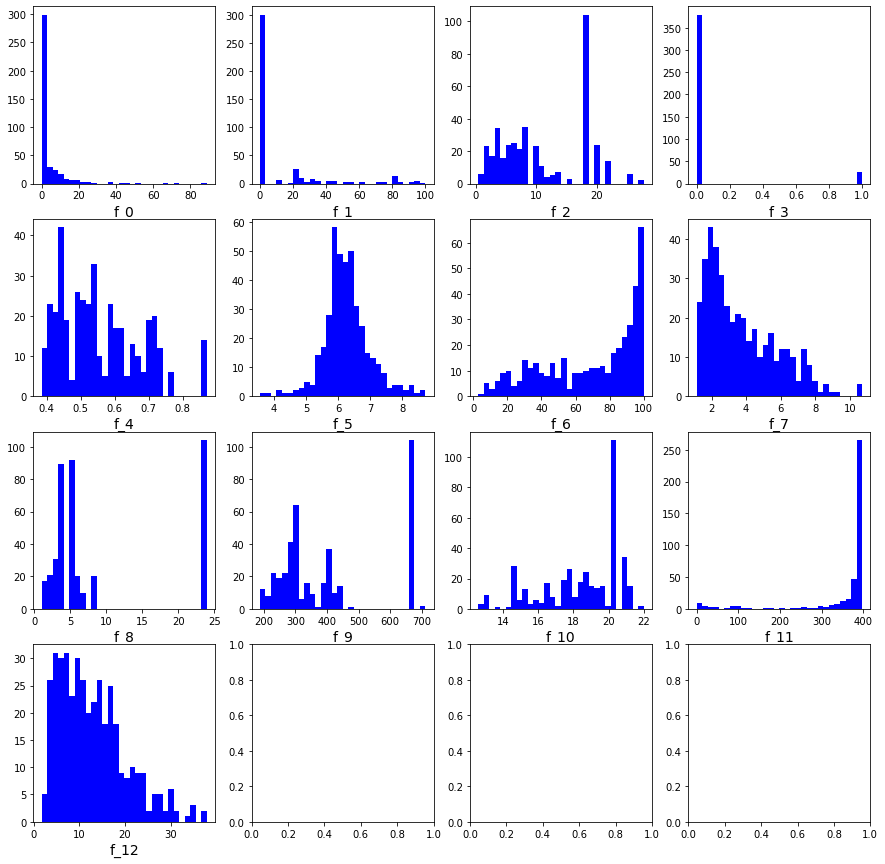

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for num in range(X_train.shape[1]):
    data = X_train[:,num].copy()
    axes[num//4, num%4].hist(data, bins=30, color="blue")
    axes[num//4, num%4].set_xlabel(f'f_{num}', fontsize=14)

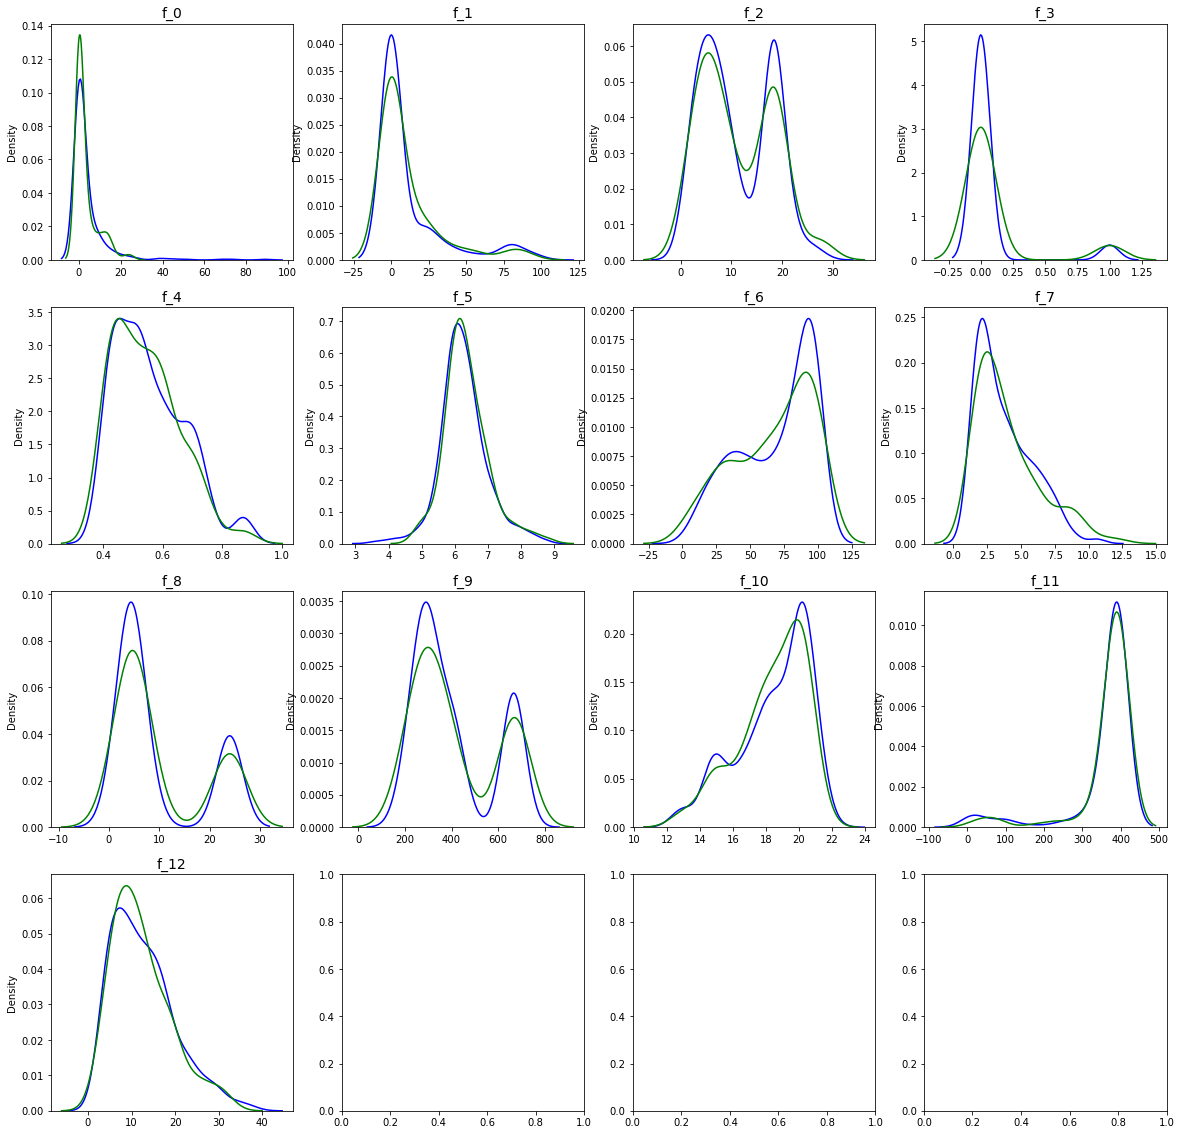

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i in range(X_train.shape[1]):
    train_data, test_data = X_train[:,i].copy(), X_test[:,i].copy()
    sns.kdeplot(train_data, ax=axes[i//4, i%4], color="blue", label="train")
    sns.kdeplot(test_data, ax=axes[i//4, i%4], color="green", label="test")
   
    axes[i//4, i%4].set_title(f'f_{i}', fontsize=14)

## Анализ распределения целевой переменной

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:title={'center':'Log Normal'}>

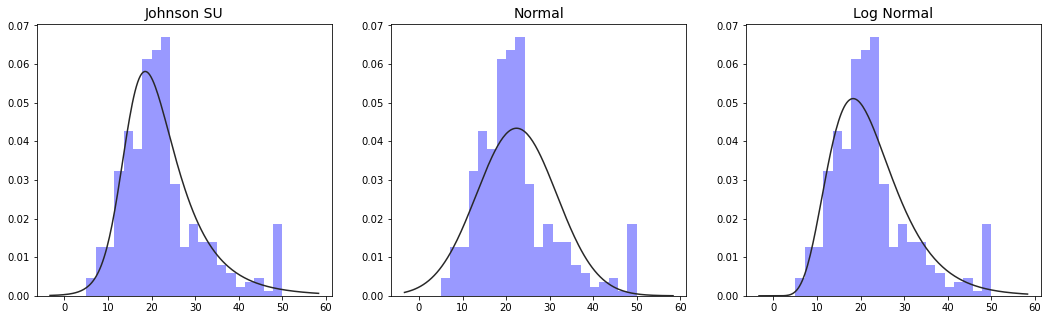

In [10]:
target = y_train
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


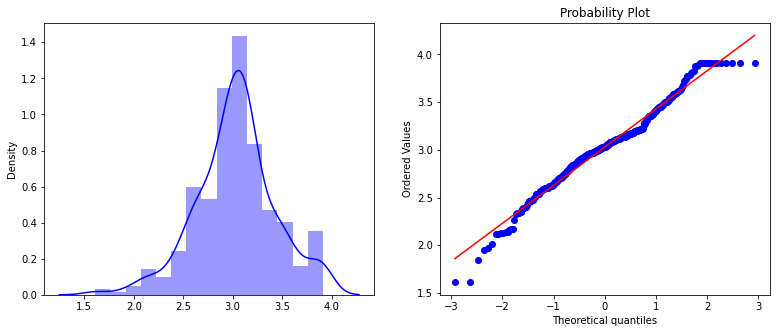

In [11]:
target = np.log(y_train)
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(target, bins=15, color="blue")
plt.subplot(122)
probplot(target, plot=plt)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


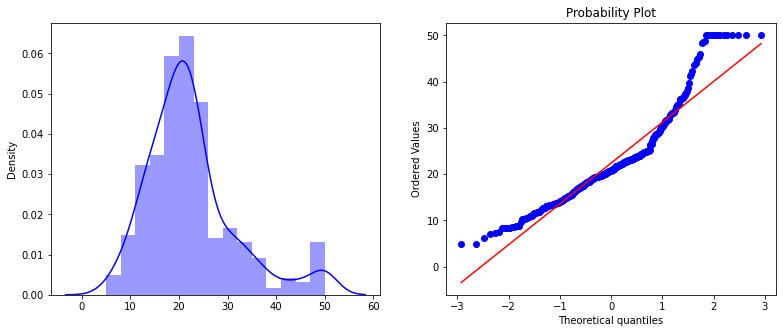

In [12]:
target = y_train
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(target, bins=15, color="blue")
plt.subplot(122)
probplot(target, plot=plt)
plt.show()

### Нормализуем данные

In [13]:
X_train_w=normalize(X_train)
X_test_w = normalize(X_test)
y_train_w = np.log(y_train)
y_test_w = np.log(y_test)

### Сделаем тестовую модель, что бы проверить как работает и с какими данными лучше работать

In [28]:
# Заполняем модель, формируя граф передачи тензоров
x_input = Input(shape=(13))
x = Flatten()(x_input)
x = Dense(200, activation='sigmoid')(x)
x = Dense(300, activation='relu')(x)
x_output = Dense(1)(x)
model=Model(x_input,x_output,name = '22')

In [29]:
opt_adam = keras.optimizers.Adam()
loss=tf.keras.losses.MeanSquaredError()
metric= coeff_determination


In [30]:
model.compile(optimizer=opt_adam,
              loss=loss,
              metrics=[metric])

In [31]:
ww = model.get_weights()

In [32]:
# Данныее без изменений
model.set_weights(ww)
hh_1 = model.fit(X_train,y_train,epochs=10,validation_data=(X_test, y_test),verbose=1)
model.evaluate(X_test,y_test)

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 338.0302 - coeff_determination: -3.3405 - val_loss: 138.9529 - val_coeff_determination: -1.0531
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 93.7322 - coeff_determination: -0.1654 - val_loss: 84.1820 - val_coeff_determination: -0.1009
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 79.3859 - coeff_determination: 0.0463 - val_loss: 66.0817 - val_coeff_determination: -0.0125
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 67.6979 - coeff_determination: 0.2033 - val_loss: 61.1092 - val_coeff_determination: 0.0259
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 63.2581 - coeff_determination: 0.2226 - val_loss: 58.1068 - val_coeff_determination: 0.0818
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 61.1589 - coeff_determination: 0.2611 - val_loss: 57.9257 - val_coeff_determination: 0.0503
Epoch 7/

[53.99225616455078, 0.08974704146385193]

In [33]:
# Изменим таргет, а данные нет
model.set_weights(ww)
hh_1 = model.fit(X_train,y_train_w,epochs=100,validation_data=(X_test, y_test_w),verbose=0)
model.evaluate(X_test,y_test_w)

4/4 [==============================] - 0s 1ms/step - loss: 0.0546 - coeff_determination: 0.4393


[0.054646991193294525, 0.4392910897731781]

In [34]:
# Изменим таргет, и данные 
model.set_weights(ww)
hh_1 = model.fit(X_train_w,y_train_w,epochs=100,validation_data=(X_test_w, y_test_w),verbose=0)
model.evaluate(X_test_w,y_test_w)

4/4 [==============================] - 0s 1ms/step - loss: 0.1226 - coeff_determination: -0.3316


[0.12261556833982468, -0.331577330827713]

In [35]:
# Изменим данные, а  таргет нет 
model.set_weights(ww)
hh_1 = model.fit(X_train_w,y_train,epochs=10,validation_data=(X_test_w, y_test),verbose=1)
model.evaluate(X_test_w,y_test)

Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 249.3638 - coeff_determination: -2.0202 - val_loss: 105.9249 - val_coeff_determination: -0.3557
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 96.5090 - coeff_determination: -0.1701 - val_loss: 97.1709 - val_coeff_determination: -0.4485
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 90.4356 - coeff_determination: -0.1582 - val_loss: 82.3697 - val_coeff_determination: -0.1556
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 86.0574 - coeff_determination: -0.0768 - val_loss: 83.4243 - val_coeff_determination: -0.2127
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 83.8865 - coeff_determination: -0.0218 - val_loss: 81.4148 - val_coeff_determination: -0.1658
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 83.6375 - coeff_determination: -0.0324 - val_loss: 80.9299 - val_coeff_determination: -0.1582
Ep

[79.4380111694336, -0.144502654671669]

Как видно, лучше вообще не трогать данные или в крайнем случае менятьт таргет  
Я не буду модифицировать данные

In [23]:
N=100
models=[]
x_input = Input(shape=(13))
levels=np.arange(1,11)
num_n = np.arange(10,1001)
fun = ['relu','sigmoid','relu','relu']

for _ in range(N):
    level = np.random.choice(levels)
    x = Flatten()(x_input)
    my_level = []
    for l in range(level):
        n = np.random.choice(num_n)
        f = np.random.choice(fun)
        x=Dense(n,activation=f)(x)
        my_level.append((n,f))
    x_output = Dense(1)(x)   
    name=f'{level}_{my_level}'
    name =re.sub("[\[\]()'',]",'',name)
    name=re.sub(" ",'_',name)
    model=Model(x_input,x_output,name=name)
    models.append((model,model.get_weights()))

In [24]:
for i in range(5):
    print(models[i][0].name)


9_196_relu_562_relu_368_sigmoid_261_relu_255_relu_919_relu_741_relu_930_relu_427_sigmoid
7_44_relu_636_relu_389_relu_427_relu_505_relu_149_relu_336_relu
9_199_relu_16_relu_770_relu_876_relu_554_relu_942_sigmoid_302_sigmoid_665_relu_807_sigmoid
1_300_relu
3_980_relu_419_relu_100_sigmoid


In [25]:
len(models)

100

In [26]:
%%time
result = pd.DataFrame()
for model in models:
    for opt in [SGD(), RMSprop(),Adam()]:
        for epochs in [50,100,150]:
            model[0].compile(optimizer=opt,
                          loss=tf.keras.losses.MeanSquaredError(),
                          metrics=[coeff_determination])
            model[0].set_weights(model[1])
            hh = model[0].fit(X_train,y_train,epochs=epochs,\
                              validation_data=(X_test, y_test),verbose=0,batch_size=1000)
            answer = hh.history['val_coeff_determination'][-1]
            d={
                'name':model[0].name,
                'epoch': epochs,
                'opt':opt,
                'res':answer
            }
            result = result.append(d,ignore_index=True)
            


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [36]:
result.sort_values('res',ascending=False,inplace=True)
result.head(25)

,epoch,name,opt,res
815,150.0,5_79_relu_652_relu_588_sigmoid_275_sigmoid_972...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.691278
320,150.0,3_183_relu_501_relu_377_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.687156
230,150.0,6_356_sigmoid_199_relu_717_sigmoid_134_sigmoid...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.682820
284,150.0,2_110_relu_792_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.679319
698,150.0,7_527_sigmoid_930_sigmoid_703_relu_96_sigmoid_...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.677507
422,150.0,5_440_sigmoid_687_relu_675_sigmoid_371_relu_57...,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.671526
655,100.0,10_118_sigmoid_414_relu_163_sigmoid_560_relu_1...,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.669009
166,100.0,6_917_relu_393_relu_477_sigmoid_537_relu_704_s...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.666107
572,150.0,8_627_sigmoid_642_sigmoid_219_relu_791_relu_83...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.663719
635,150.0,5_179_sigmoid_472_sigmoid_215_relu_385_relu_18...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.663419


### Возмем первые топ 10 можелей и проверим их на устойчивость

In [44]:
def name_model(name):
    for m in models:
        if m[0].name == name:
            return m
        
best_models=[]
for i in range(5):
    my_iter = result.iloc[i]
    best_models.append((name_model(my_iter['name']),my_iter['epoch'],my_iter['opt']))
    

In [54]:
best_models[0][0][0].name

'5_79_relu_652_relu_588_sigmoid_275_sigmoid_972_relu'

In [83]:
%%time
test_num = 10
best_result = pd.DataFrame()
for m in best_models:
    testing=[]
    for _ in range (test_num):
        
        m[0][0].set_weights(m[0][1])
        hh = m[0][0].fit(X_train,y_train,epochs=int(m[1]),\
                          validation_data=(X_test, y_test),verbose=0,batch_size=1000)
        answer = hh.history['val_coeff_determination'][-1]
        testing.append(answer)
    testing = np.array(testing)
    d={
        'name':m[0][0].name,
        'epoch': m[1],
        'opt':m[2],
        'res_min':testing.min(),
        'res_max':testing.max(),
        'res_mean':testing.mean(),
        'res_std':testing.std(),
        'res_median':np.median(testing)
    }
    best_result = best_result.append(d,ignore_index=True)

Wall time: 1min 50s


In [84]:
best_result

,epoch,name,opt,res_max,res_mean,res_median,res_min,res_std
0,150.0,5_79_relu_652_relu_588_sigmoid_275_sigmoid_972...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.477138,0.421788,0.424489,0.367012,0.039506
1,150.0,3_183_relu_501_relu_377_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.235795,0.160346,0.163098,0.089843,0.044500
2,150.0,6_356_sigmoid_199_relu_717_sigmoid_134_sigmoid...,<tensorflow.python.keras.optimizer_v2.rmsprop....,-0.005656,-0.005660,-0.005661,-0.005663,0.000002
3,150.0,2_110_relu_792_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.331419,0.300247,0.297880,0.278128,0.014162
4,150.0,7_527_sigmoid_930_sigmoid_703_relu_96_sigmoid_...,<tensorflow.python.keras.optimizer_v2.rmsprop....,-0.005565,-0.005567,-0.005567,-0.005569,0.000001


То же самое с нормализованныйм таргетом

In [86]:
%%time
test_num = 10
best_result = pd.DataFrame()
for m in best_models:
    testing=[]
    for _ in range (test_num):
        m[0][0].set_weights(m[0][1])
        hh = m[0][0].fit(X_train,y_train_w,epochs=int(m[1]),\
                          validation_data=(X_test, y_test_w),verbose=0,batch_size=1000)
        answer = hh.history['val_coeff_determination'][-1]
        testing.append(answer)
    testing = np.array(testing)
    d={
        'name':m[0][0].name,
        'epoch': m[1],
        'opt':m[2],
        'res_min':testing.min(),
        'res_max':testing.max(),
        'res_mean':testing.mean(),
        'res_std':testing.std(),
        'res_median':np.median(testing)
    }
    best_result = best_result.append(d,ignore_index=True)
best_result    

Wall time: 1min 52s


,epoch,name,opt,res_max,res_mean,res_median,res_min,res_std
0,150.0,5_79_relu_652_relu_588_sigmoid_275_sigmoid_972...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.362295,0.362295,0.362295,0.362295,0.0
1,150.0,3_183_relu_501_relu_377_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.629186,0.629186,0.629186,0.629186,0.0
2,150.0,6_356_sigmoid_199_relu_717_sigmoid_134_sigmoid...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.587740,0.587740,0.587740,0.587740,0.0
3,150.0,2_110_relu_792_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.580756,0.580756,0.580756,0.580756,0.0
4,150.0,7_527_sigmoid_930_sigmoid_703_relu_96_sigmoid_...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.510973,0.510973,0.510973,0.510973,0.0


все нормализуем

In [85]:
%%time
test_num = 10
best_result = pd.DataFrame()
for m in best_models:
    testing=[]
    for _ in range (test_num):
        
        m[0][0].set_weights(m[0][1])
        hh = m[0][0].fit(X_train_w,y_train_w,epochs=int(m[1]),\
                          validation_data=(X_test_w, y_test_w),verbose=0,batch_size=1000)
        answer = hh.history['val_coeff_determination'][-1]
        testing.append(answer)
    testing = np.array(testing)
    d={
        'name':m[0][0].name,
        'epoch': m[1],
        'opt':m[2],
        'res_min':testing.min(),
        'res_max':testing.max(),
        'res_mean':testing.mean(),
        'res_std':testing.std(),
        'res_median':np.median(testing)
    }
    best_result = best_result.append(d,ignore_index=True)
best_result   

Wall time: 1min 51s


,epoch,name,opt,res_max,res_mean,res_median,res_min,res_std
0,150.0,5_79_relu_652_relu_588_sigmoid_275_sigmoid_972...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.167000,0.167000,0.167000,0.167000,0.0
1,150.0,3_183_relu_501_relu_377_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.392533,0.392533,0.392533,0.392533,0.0
2,150.0,6_356_sigmoid_199_relu_717_sigmoid_134_sigmoid...,<tensorflow.python.keras.optimizer_v2.rmsprop....,-0.002787,-0.002787,-0.002787,-0.002787,0.0
3,150.0,2_110_relu_792_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.356846,0.356846,0.356846,0.356846,0.0
4,150.0,7_527_sigmoid_930_sigmoid_703_relu_96_sigmoid_...,<tensorflow.python.keras.optimizer_v2.rmsprop....,-0.003242,-0.003242,-0.003242,-0.003242,0.0


Нормализуем данные без таргета

In [87]:
%%time
test_num = 10
best_result = pd.DataFrame()
for m in best_models:
    testing=[]
    for _ in range (test_num):
        
        m[0][0].set_weights(m[0][1])
        hh = m[0][0].fit(X_train_w,y_train,epochs=int(m[1]),\
                          validation_data=(X_test_w, y_test),verbose=0,batch_size=1000)
        answer = hh.history['val_coeff_determination'][-1]
        testing.append(answer)
    testing = np.array(testing)
    d={
        'name':m[0][0].name,
        'epoch': m[1],
        'opt':m[2],
        'res_min':testing.min(),
        'res_max':testing.max(),
        'res_mean':testing.mean(),
        'res_std':testing.std(),
        'res_median':np.median(testing)
    }
    best_result = best_result.append(d,ignore_index=True)
best_result 

Wall time: 1min 51s


,epoch,name,opt,res_max,res_mean,res_median,res_min,res_std
0,150.0,5_79_relu_652_relu_588_sigmoid_275_sigmoid_972...,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.034091,0.034091,0.034091,0.034091,0.0
1,150.0,3_183_relu_501_relu_377_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.295191,0.295191,0.295191,0.295191,0.0
2,150.0,6_356_sigmoid_199_relu_717_sigmoid_134_sigmoid...,<tensorflow.python.keras.optimizer_v2.rmsprop....,-0.005558,-0.005558,-0.005558,-0.005558,0.0
3,150.0,2_110_relu_792_sigmoid,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.294622,0.294622,0.294622,0.294622,0.0
4,150.0,7_527_sigmoid_930_sigmoid_703_relu_96_sigmoid_...,<tensorflow.python.keras.optimizer_v2.rmsprop....,-0.005597,-0.005597,-0.005597,-0.005597,0.0
